In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender
import lsst.pex.exceptions
import lsst.meas.extensions.gaap

from kuaizi.display import display_single
from astropy.io import fits
from astropy.table import Table, hstack

In [2]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

## Try gaap with reference catalog

In [4]:
# Load Merian catalog as reference
filt = 'N708'
tract = 9813
patch = 68
patch_old = f'{patch % 9},{patch // 9}'

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)

refCat = butler.get(
    'deepCoadd_ref',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)
# parents = np.arange(0, 100, 1) #np.arange(0, 200, 1)
# temp = refCat[parents[0]:parents[-1] + 1]
# for parent in parents:
#     childrens = np.where(refCat['parent'] == refCat['id'][parent])[0]
#     temp.extend(refCat[childrens[0]:childrens[-1] + 1])
# refCat = temp.copy()

refExposure = butler.get(
    'deepCoadd_calexp',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

refCatInBand = butler.get(
    'deepCoadd_meas',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)
# temp = refCatInBand[parents[0]:parents[-1] + 1]
# for parent in parents:
#     childrens = np.where(refCatInBand['parent'] == refCatInBand['id'][parent])[0]
#     temp.extend(refCatInBand[childrens[0]:childrens[-1] + 1])
# refCatInBand = temp.copy()

footprintCatInBand = butler.get(
    'deepCoadd_scarletModelData',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

expID = dict(tract=tract, patch=patch, band=filt, skymap='hsc_rings_v1')

In [5]:
len(refCat)

26358

In [5]:
hsc_type = 'S20A'
if hsc_type == 'w40':
    exposure = lsst.afw.image.ExposureF(
        f'/scratch/arunj/deepCoadd_calexp_9813_{patch}_i_hsc_rings_v1_HSC_runs_RC2_w_2022_40_DM-36356_20221006T193226Z.fits'
    )
elif hsc_type == 'w04':
    exposure = lsst.afw.image.ExposureF(
        f"/projects/MERIAN/repo/HSC/runs/RC2/w_2022_04/DM-33402/20220128T212035Z/deepCoadd_calexp/9813/{patch}/i/deepCoadd_calexp_9813_{patch}_i_hsc_rings_v1_HSC_runs_RC2_w_2022_04_DM-33402_20220128T212035Z.fits"
    )
elif hsc_type == 'S20A':
    exposure = lsst.afw.image.ExposureF(
        f"/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/{patch_old}/calexp-HSC-I-{tract}-{patch_old}.fits"
    )
    
from hsc_gaap.gaap import checkWcsEqual
if checkWcsEqual(exposure.getWcs(), refExposure.getWcs()):
    exposure.setWcs(refExposure.getWcs())

Overriding default configuration file with /projects/HSC/LSST/stack_20220527/conda/envs/lsst-scipipe-4.1.0/share/eups/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


In [6]:
# exposure = refExposure
# exposure.mask.clearAllMaskPlanes()

rsync -zva --progress jiaxuanl@tiger.princeton.edu://projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/5,3/calexp-HSC-I-9813-5,3.fits ./

In [7]:
import logging

In [8]:
measureConfig = lsst.meas.base.ForcedPhotCoaddConfig()
# measureConfig.footprintDatasetName = 'DeblendedFlux'
measureConfig.footprintDatasetName = 'ScarletModelData'
# measureConfig.measurement.slots.modelFlux='modelfit_CModel'

# measureConfig.measurement.doReplaceWithNoise = False


measureConfig.measurement.plugins.names.add("base_SdssShape")
measureConfig.measurement.plugins.names.add("base_GaussianFlux")
measureConfig.measurement.plugins.names.add("base_PsfFlux")
measureConfig.measurement.plugins.names.add("base_SdssCentroid")
measureConfig.measurement.plugins.names.add('modelfit_DoubleShapeletPsfApprox')
measureConfig.measurement.plugins.names.add('modelfit_CModel')
measureConfig.measurement.plugins.names.add('base_Blendedness')

measureConfig.measurement.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
# measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doOptimalPhotometry = True
# measureConfig.measurement.plugins["ext_gaap_GaapFlux"].sigmas = [0.5, 0.75, 1.0, 1.5, 2.0]
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].sigmas = [0.5, 1.0, 1.5]

photTask = lsst.meas.base.ForcedPhotCoaddTask(refSchema=refCat.schema, config=measureConfig)
photTask.log.setLevel('DEBUG') # DEBUG

if not photTask.log.hasHandlers():
    logger = logging.getLogger('simple_example')
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    photTask.log.addHandler(ch)

In [80]:
25 * 5 * 81 * 371 / 60 # cpu hour

62606.25

In [77]:
25 * 5 * 81 / 30 / 60 * 371 / 24 / 80

1.0869140625

In [16]:
import lsst.meas.modelfit.psf.psfContinued
import lsst.meas.modelfit.optimizer.optimizer
import lsst.meas.modelfit
import lsst.meas.modelfit.cmodel.cmodelContinued
import lsst.meas.modelfit.pixelFitRegion.pixelFitRegion
import lsst.meas.modelfit.cmodel.cmodel

In [17]:
measCat, exposureID = photTask.generateMeasCat(exposureDataId=butler.registry.expandDataId(expID), 
                                               exposure=exposure, 
                                               refCat=refCat, 
                                               refCatInBand=refCatInBand, 
                                               refWcs=refExposure.wcs, 
                                               idPackerName='tract_patch', 
                                               footprintData=footprintCatInBand)

In [18]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
photTask.run(measCat, exposure, refCat=refCat, refWcs=refExposure.wcs, exposureId=exposureID)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))
cat2 = measCat.copy(deep=True).asAstropy()

ssssddddddd
Performing forced measurement on 615 sources
Mask plane "THISDET": plane 18, bitmask 262144 = 0x40000
Mask plane "OTHERDET": plane 19, bitmask 524288 = 0x80000
Measured from image: clipped mean = 0.00663994, stdev = 0.0549733


# Starting the measureTask at  Wed Dec  7 20:37:40 2022


Using noise generator: FixedGaussianNoiseGenerator: mean=0.00663994, std=0.0549733


FatalAlgorithmError: CModel forced measurement currently requires the measurement image to have the same Wcs as the reference catalog (this is a temporary limitation).

In [19]:
refExposure.wcs == exposure.wcs

False

In [485]:
# refCat.copy(deep=True).asAstropy()

In [ ]:
## Now it's using Merian footprints on RC2 w40.

In [5]:
def writeObjectTable(measCat, band='i', save=True):
    import astropy.units as u
    from astropy.table import QTable
    
    outCat = measCat.copy(deep=True).asAstropy()
    outCat['coord_ra'] = outCat['coord_ra'].to(u.deg)
    outCat['coord_dec'] = outCat['coord_dec'].to(u.deg)

    old_gaap_cols = [
        item for item in measCat.schema.getNames() if ('gaap' in item and 'apCorr' not in item) | ('base_PsfFlux_instFlux' in item) | ('base_CircularApertureFlux' in item)]
    outCat = outCat[['id', 'coord_ra', 'coord_dec'] + old_gaap_cols]
    
    # PhotCalib
    for col in old_gaap_cols:
        if 'instFlux' in col:
            outCat[col] = outCat[col].value * \
                exposure.getPhotoCalib().instFluxToNanojansky(1) * u.nanomaggy

    new_gaap_cols = []
    for col in old_gaap_cols:
        name = col.replace('ext_gaap_GaapFlux', f'{band}_gaap')
        name = name.replace('_instFlux', 'Flux').replace('PsfFlux', 'Psf')
        if 'Flux' in name:
            aper = name.split(
                "x_")[-1].replace('FluxErr', '').replace('Flux', '')
            name = name.replace('_1_15x', '')
            name = name.replace('_' + aper, aper.replace('_', 'p'))

        if 'flag' in name:
            aper = name.split(
                "x_")[-1].replace('_flag_bigPsf', '').replace('_flag', '')
            name = name.replace('_1_15x', '')
            if not 'gauss' in name:
                name = name.replace(
                    '_' + aper, aper.replace('_', 'p') + 'Flux')
        new_gaap_cols.append(name)
    
    outCat.rename_columns(old_gaap_cols, new_gaap_cols)
    outCat = QTable(outCat)
    return outCat

In [46]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [49]:
from hsc_gaap.gaap import joinMerianCatPatches
from astropy.table import vstack
cat2 = writeObjectTable(measCat, band='i')
cat_ref = joinMerianCatPatches([patch])
cat_ref = cat_ref[np.in1d(cat_ref['objectId'], cat2['id'])]
cat2.remove_columns(['id', 'coord_ra', 'coord_dec'])
cat = hstack([cat_ref, cat2])

In [74]:
# cat.write('/tigress/jiaxuanl/public_html/Merian/patch23_test_gaap_scarlet_noisy.fits')

Text(0, 0.5, 'noise replaced / noisy')

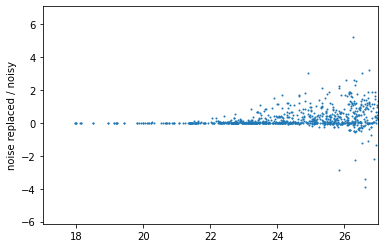

In [84]:
plt.scatter(30 - 2.5 * np.log10(cat['i_gaap1p0Flux'].value), 
            -2.5 * np.log10(cat['i_gaap1p0Flux'].value / cat_new['i_gaap1p0Flux'].value), s=1)

plt.xlim(17, 27)
plt.ylabel('noise replaced / noisy')

In [58]:
# Load HSC catalog
filt = 'i'
tract = 9813
patch = 22
patch_old = f'{patch % 9},{patch // 9}'

repo = '/projects/HSC/repo/main'
collection = 'HSC/runs/RC2/w_2022_40/DM-36151'
instr = 'HSC'

import lsst.daf.butler as dafButler
butler = dafButler.Butler(repo)
dataId = dict(tract=tract, patch=patch, band=filt)

hscCat = butler.get(
    'deepCoadd_obj',
    collections=collection,
    dataId=dataId,
    instrument=instr,
    skymap='hsc_rings_v1',
)#.asAstropy()
# hscCat = writeObjectTable(hscCat, band='i')
# hscCat.write('/tigress/jiaxuanl/public_html/Merian/w40_i_gaap_patch22.fits')

In [68]:
hscCat['meas']['i'].columns.to_list()

['base_Blendedness_abs',
 'base_Blendedness_abs_child_instFlux',
 'base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_parent_instFlux',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_xy',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_flag',
 'base_Blendedness_flag_noCentroid',
 'base_Blendedness_flag_noShape',
 'base_Blendedness_old',
 'base_Blendedness_raw',
 'base_Blendedness_raw_child_instFlux',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_parent_instFlux',
 'base_Blendedness_raw_parent_xx',
 'base_Blendedness_raw_parent_xy',
 'base_Blendedness_raw_parent_yy',
 'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_flag_sincCoeffsTruncated',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'b

In [30]:
hscs = []
for patch in [22, 23, 24, 25]:
    # Load HSC catalog
    filt = 'i'
    tract = 9813
#     patch = 22
    patch_old = f'{patch % 9},{patch // 9}'

    repo = '/projects/HSC/repo/main'
    collection = 'HSC/runs/RC2/w_2022_40/DM-36151'
    instr = 'HSC'

    import lsst.daf.butler as dafButler
    butler = dafButler.Butler(repo)
    dataId = dict(tract=tract, patch=patch, band=filt)

    hscCat = butler.get(
        'deepCoadd_forced_src',
        collections=collection,
        dataId=dataId,
        instrument=instr,
        skymap='hsc_rings_v1',
    )
    hscCat = writeObjectTable(hscCat, band='i')
    
    measCat = butler.get(
        'deepCoadd_meas',
        collections=collection,
        dataId=dataId,
        instrument=instr,
        skymap='hsc_rings_v1',
    ).asAstropy()
    hscCat['base_Blendedness_abs'] = measCat['base_Blendedness_abs']
    hscCat['base_Blendedness_old'] = measCat['base_Blendedness_old']
    hscCat['deblend_blendedness'] = measCat['deblend_blendedness']
    hscs.append(hscCat)
#     hscCat.write('/tigress/jiaxuanl/public_html/Merian/w40_i_gaap_patch22.fits')

In [31]:
from astropy.table import vstack

In [32]:
hsc = vstack(hscs)

In [34]:
len(hsc)

145186

In [36]:
hsc.write('/tigress/jiaxuanl/public_html/Merian/w40_i_gaap_patch22_25.fits', overwrite=True)

In [43]:
cat2 = measCat.copy(deep=True).asAstropy()
cat_ref = refCat.copy(deep=True).asAstropy()
i_mags = 27 - 2.5 * np.log10(
    cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'] * exposure.getPhotoCalib().instFluxToNanojansky(1))
n708_mags = 27 - 2.5 * np.log10(
    cat_ref['ext_gaap_GaapFlux_1_15x_1_0_instFlux'] * exposure.getPhotoCalib().instFluxToNanojansky(1))
flag = (cat2['deblend_nChild'] > 0)

KeyError: 'ext_gaap_GaapFlux_1_15x_1_0_instFlux'

In [53]:
cat2 = measCat.copy(deep=True).asAstropy()
cat_ref = refCat.copy(deep=True).asAstropy()
i_mags = 27 - 2.5 * np.log10(
    cat2['base_PsfFlux_instFlux'] * exposure.getPhotoCalib().instFluxToNanojansky(1))
n708_mags = 27 - 2.5 * np.log10(
    cat_ref['base_PsfFlux_instFlux'] * exposure.getPhotoCalib().instFluxToNanojansky(1))
flag = (cat2['deblend_nChild'] > 0)

(-3.0, 3.0)

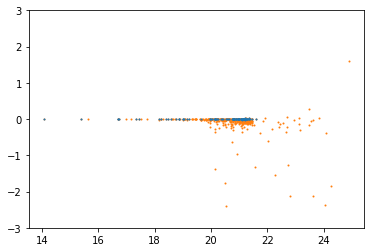

In [54]:
plt.scatter(i_mags[flag], (i_mags - n708_mags)[flag], s=1, zorder=2)
plt.scatter(i_mags[~flag], (i_mags - n708_mags)[~flag], s=1)

plt.ylim(-3, 3)

(-3.0, 3.0)

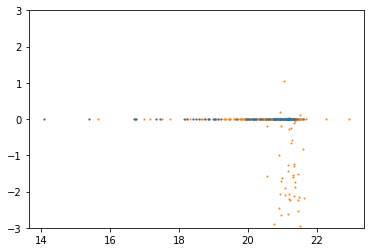

In [46]:
plt.scatter(i_mags[flag], (i_mags - n708_mags)[flag], s=1, zorder=2)
plt.scatter(i_mags[~flag], (i_mags - n708_mags)[~flag], s=1)

plt.ylim(-3, 3)

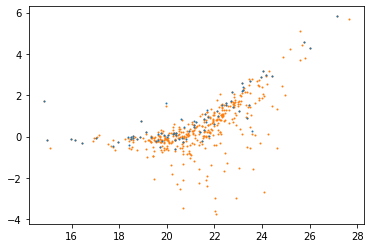

In [569]:
plt.scatter(i_mags[flag], (i_mags - n708_mags)[flag], s=1, zorder=2)
plt.scatter(i_mags[~flag], (i_mags - n708_mags)[~flag], s=1)

# plt.ylim(-3, 3)

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

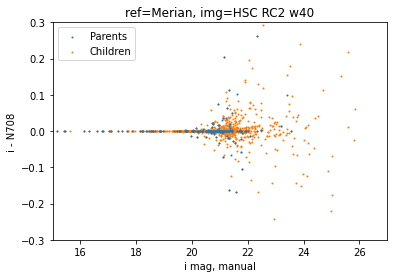

In [54]:
flag = (cat['deblend_nChild'] > 0)

plt.scatter(27 - 2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data / cat[flag]['N708_gaap1p0Flux']), 
            s=1, label='Parents', zorder=10)

plt.scatter(27 - 2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data / cat[~flag]['N708_gaap1p0Flux']), 
            s=1, alpha=1, label='Children')

plt.xlim(15, 27)
plt.ylim(-.3, .3)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

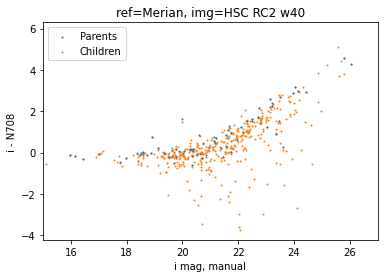

In [45]:
flag = (cat['deblend_nChild'] > 0)

plt.scatter(27 - 2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data / cat[flag]['N708_gaap1p0Flux']), 
            s=1, label='Parents', zorder=10)

plt.scatter(27 - 2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data / cat[~flag]['N708_gaap1p0Flux']), 
            s=1, alpha=1, label='Children')

plt.xlim(15, 27)
# plt.ylim(-3, 3)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

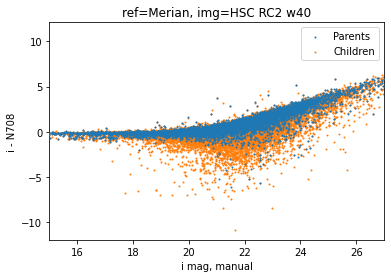

In [556]:
flag = (cat['deblend_nChild'] > 0)

plt.scatter(27 - 2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data / cat[flag]['N708_gaap1p0Flux']), 
            s=1, label='Parents', zorder=10)

plt.scatter(27 - 2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data / cat[~flag]['N708_gaap1p0Flux']), 
            s=1, alpha=1, label='Children')

plt.xlim(15, 27)
# plt.ylim(-3, 3)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

In [551]:
cat.write('/tigress/jiaxuanl/public_html/Merian/patch23_full_gaap.fits')

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

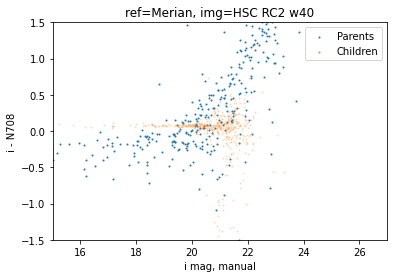

In [293]:
plt.scatter(27 - 2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data / cat[flag]['N708_gaap1p0Flux']), 
            s=1, label='Parents')

plt.scatter(27 - 2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data / cat[~flag]['N708_gaap1p0Flux']), 
            s=1, alpha=0.2, label='Children')

plt.xlim(15, 27)
plt.ylim(-1.5, 1.5)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

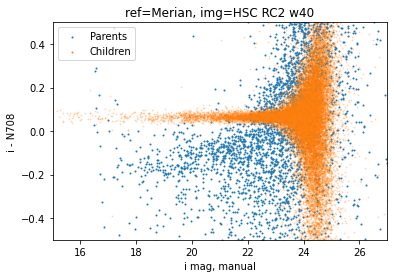

In [108]:
plt.scatter(30 - 2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[flag]['i_gaap1p0Flux'].data / cat[flag]['N708_gaap1p0Flux']), 
            s=1, label='Parents')

plt.scatter(30 - 2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat[~flag]['i_gaap1p0Flux'].data / cat[~flag]['N708_gaap1p0Flux']), 
            s=1, alpha=0.2, label='Children')

plt.xlim(15, 27)
plt.ylim(-0.5, 0.5)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

In [29]:
plt.scatter(30 - 2.5 * np.log10(cat[flag]['base_PsfFlux'].data), 
            -2.5 * np.log10(cat[flag]['base_PsfFlux'].data / cat[flag]['N708_psfFlux']), 
            s=1, label='Parents', zorder=3)

plt.scatter(30 - 2.5 * np.log10(cat[~flag]['base_PsfFlux'].data), 
            -2.5 * np.log10(cat[~flag]['base_PsfFlux'].data / cat[~flag]['N708_psfFlux']), 
            s=1, alpha=1, label='Children')

# plt.xlim(15, 27)
# plt.ylim(-1, 1)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

NameError: name 'cat' is not defined

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

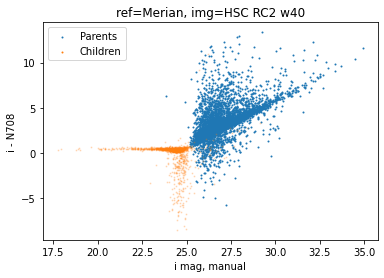

In [191]:
plt.scatter(30 - 2.5 * np.log10(cat[flag]['base_PsfFlux'].data), 
            -2.5 * np.log10(cat[flag]['base_PsfFlux'].data / cat[flag]['N708_psfFlux']), 
            s=1, label='Parents')

plt.scatter(30 - 2.5 * np.log10(cat[~flag]['base_PsfFlux'].data), 
            -2.5 * np.log10(cat[~flag]['base_PsfFlux'].data / cat[~flag]['N708_psfFlux']), 
            s=1, alpha=0.2, label='Children')

# plt.xlim(15, 27)
# plt.ylim(-1, 1)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

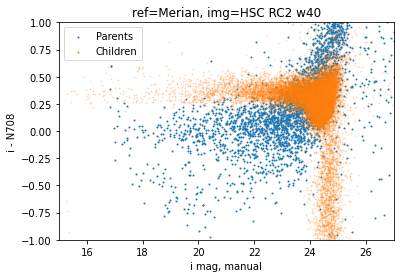

In [115]:
plt.scatter(30 - 2.5 * np.log10(cat[flag]['base_PsfFlux'].data), 
            -2.5 * np.log10(cat[flag]['base_PsfFlux'].data / cat[flag]['N708_psfFlux']), 
            s=1, label='Parents')

plt.scatter(30 - 2.5 * np.log10(cat[~flag]['base_PsfFlux'].data), 
            -2.5 * np.log10(cat[~flag]['base_PsfFlux'].data / cat[~flag]['N708_psfFlux']), 
            s=1, alpha=0.2, label='Children')

plt.xlim(15, 27)
plt.ylim(-1, 1)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

In [92]:
10**(0.4 * 0.07)

1.066596121230258

In [97]:
photTask.log.name

'lsst.forcedPhotCoadd'

rsync -zva --progress jiaxuanl@tiger.princeton.edu://projects/MERIAN/repo/S20A/gaapTable/9813/gaap_9813_23_Merian_RC2_i.fits ./

In [48]:
cat = hstack([cat_ref, cat2])
cat.write('/projects/MERIAN/repo/S20A/gaapTable/9813/gaap_9813_23_Merian_RC2_i.fits')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

plt.xlim(16, 25)
# plt.ylim(-0.5, 0.5)
# plt.ylim(-0.2, 0.2)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

Text(0, 0.5, 'Delta(i), manual - RC2')

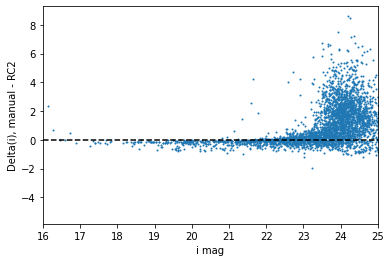

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

plt.xlim(16, 25)
# plt.ylim(-0.5, 0.5)
# plt.ylim(-0.2, 0.2)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

Text(0, 0.5, 'Delta(i), manual - RC2')

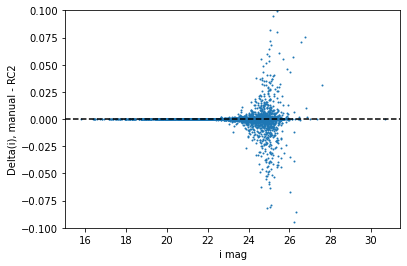

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

# plt.xlim(20, 29)
plt.ylim(-0.1, 0.1)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

In [367]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom

In [368]:
recordId = 0
shape = refCat[recordId].getShape()
shape

Quadrupole(ixx=22.467348068135465, iyy=32.38096968264305, ixy=7.092387580840181)

In [369]:
display.getMaskPlaneColor()

{'BAD': 'red',
 'CR': 'magenta',
 'EDGE': 'yellow',
 'INTERPOLATED': 'green',
 'SATURATED': 'green',
 'DETECTED': 'blue',
 'DETECTED_NEGATIVE': 'cyan',
 'SUSPECT': 'yellow',
 'NO_DATA': 'orange',
 'INTRP': 'green',
 'SAT': 'green',
 'CLIPPED': 'red',
 'CROSSTALK': 'green',
 'INEXACT_PSF': 'blue',
 'NOT_DEBLENDED': 'cyan',
 'REJECTED': 'magenta',
 'SENSOR_EDGE': 'yellow',
 'STREAK': 'orange',
 'UNMASKEDNAN': 'red',
 'BRIGHT_OBJECT': 'green',
 'THISDET': 'red',
 'OTHERDET': 'green'}

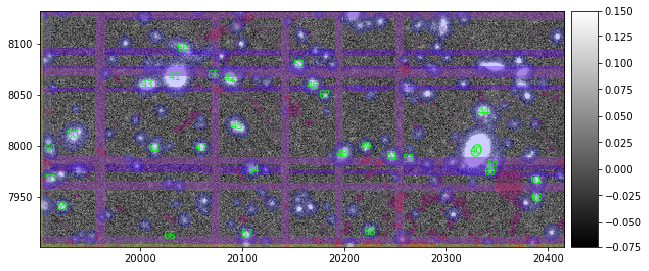

In [370]:
afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(figsize=(10, 10))
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")
# for key in display.getMaskPlaneColor().keys():
#     display.setMaskPlaneColor(key, 'IGNORE')
# display.setMaskPlaneColor('BRIGHT_OBJECT', 'green')
display.setMaskTransparency(80)

obj = refCat[recordId]
footprint = obj.getFootprint()
bbox = footprint.getBBox()
cutout = exposure[bbox]
display.mtv(cutout)
display.dot(shape, *obj.getCentroid()) #*bbox.getCenter())
# display.dot(str(obj['id'])[-2:], *obj.getCentroid())

for i in range(1, len(refCat)):
    obj = refCat[i]
    display.dot(str(obj['id'])[-2:], *obj.getCentroid()) #*bbox.getCenter())

In [362]:
recordId = 6
shape = refCatInBand[recordId].getShape()
print(shape)
print(refCatInBand[recordId]['id'])
print(refCatInBand[recordId].getCentroid())
refCatInBand[recordId].getFootprint().getCentroid()

(ixx=22.089523554274244, iyy=12.602790725678648, ixy=-6.252166957511313)
3495901618560323745
(20095, 8020)


Point2D(20094.228838295388, 8022.4226503210739)

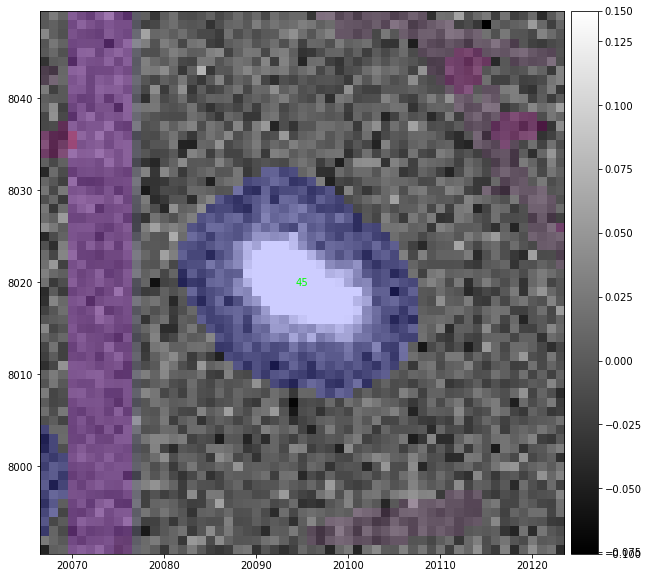

In [365]:
afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(figsize=(10, 10))
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")
# for key in display.getMaskPlaneColor().keys():
#     display.setMaskPlaneColor(key, 'IGNORE')
# display.setMaskPlaneColor('BRIGHT_OBJECT', 'green')
display.setMaskTransparency(80)

obj = refCatInBand[recordId]
footprint = obj.getFootprint()
bbox = footprint.getBBox()
cutout = exposure[bbox]
display.mtv(cutout)
# display.dot(shape, *obj.getCentroid()) # *bbox.getCenter())
# display.dot(shape, *bbox.getCenter())
display.dot(str(obj['id'])[-2:], *obj.getCentroid()) #*bbox.getCenter())

In [9]:
footprintCatInBand

In [12]:
obj = footprintCatInBand.blends[3495901618560303105]

In [20]:
child = obj.sources[3495901618560323740]

In [23]:
child.factorizedComponents

[ScarletFactorizedComponentData(xy0=(402, 69), extent=(51, 51), center=[427, 94], sed=array([1.3099676, 5.3024907], dtype=float32), morph=array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
 ScarletFactorizedComponentData(xy0=(402, 69), extent=(51, 51), center=[427, 94], sed=array([0.33459997, 0.87351996], dtype=float32), morph=array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))]